# Multivariate Gaussian

## Background

### Probability Density Function

The pdf for the multivariate Gaussian distribution is given by:

$$f(\vec{x}|\vec{\mu}, \Sigma) = (2\pi)^{-\frac{k}{2}}\det(\Sigma)^{-\frac{1}{2}}e^{-\frac{1}{2}(\vec{x} - \vec{\mu})^{T}\Sigma^{-1}(\vec{x}-\vec{\mu})}$$

where

$\vec{\mu} \in \mathbb{R}^{k}$ is the expected value vector

$\Sigma \in \mathbb{R}^{k \times k}$ is the covariance matrix

Further, we can define the Mahalanobis distance between point $\vec{x}$ and the expected value vector $\vec{\mu}$

$$\text{MD}(\vec{x}|\vec{\mu}, \Sigma) = ((\vec{x} - \vec{\mu})^{T}\Sigma^{-1}(\vec{x}-\vec{\mu}))^{\frac{1}{2}}$$

If we take the natural logarithm of the pdf, we have:

$$\ln(f(\vec{x}, \vec{\mu}, \Sigma) = -\frac{1}{2}[d\ln(2\pi) + \ln(\det(\Sigma^{-1})) + \text{MD}(\vec{x} | \vec{\mu}, \Sigma)^{2}]$$

Therefore, we can optimise for $\hat{\theta}$ and $\hat{\Sigma}$ by maximising the log function, or minimising the negative log function: 

$$\ln(f(\vec{x}, \vec{\mu}, \Sigma) = \frac{1}{2}[d\ln(2\pi) + \ln(\det(\Sigma^{-1})) + \text{MD}(\vec{x} | \vec{\mu}, \Sigma)^{2}]$$


## Modelling

In [1]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_modelling import MultivariateGaussian

In [14]:
import numpy as np

# instantiate a random number generator
rng = np.random.default_rng(100)

# define mu and sigma for the dummy sample
mu = np.array([0.5, 0.25])
# consider covariance matrix as a constant
cov = np.array([[1, 0.5],
                [0.5, 1]])

# generate multivariate normal random sample
x = rng.multivariate_normal(mu, cov, size=10000)

print(x.shape)

(10000, 2)


In [24]:
def generate_sample(sample_size, mu, covmat, random_state=10):
    rng = np.random.default_rng(random_state)
    
    return rng.multivariate_normal(mu, covmat, size=sample_size)


x = generate_sample(1000, [0, 0], [[1, 0.5], [0.5, 1]])

x.shape

(1000, 2)

In [25]:
# instantiate the MultivariateGaussian class
mg = MultivariateGaussian()
# fit the multivariate Gaussian model to the pseudo-random sample
mg.fit(x)

## Plotting contour

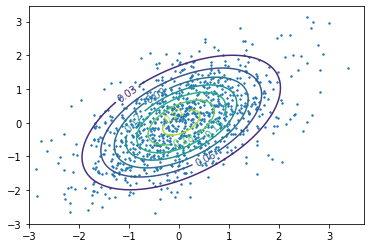

In [26]:
# generate meshgrid for plotting
xx, xy = np.meshgrid(*np.linspace(-3, 3, 100)[np.newaxis, :].repeat(2, 0))

# Need an (N, 2) array of (x, y) pairs.
x_new = np.column_stack([xx.flat, xy.flat])

# generate probabilities for meshgrid
z = mg.pdf(x_new)

# mesh contour plot
cs = plt.contour(xx, xy, z.reshape(100, 100))
plt.clabel(cs)
# plot original sample over mesh
plt.scatter(x[:, 0], x[:, 1], s=2)

## Analytic Solutions to Maximum Likelihood Estimation

We can determine the parameters $\hat{\mu}$ and $\hat{\Sigma}$ analytically, by taking the partial derivatives with respect to $\vec{\mu}$ and $\Sigma$, setting equal to zero and solving for the parameters.

In the end, we get:

$$\hat{\mu} = \frac{1}{m}\sum_{i = 1}^{m} x^{(i)} = \bar{x}$$

$$\hat{\Sigma} = \frac{1}{m} \sum_{i = 1}^{m} (x^{(i)} - \hat{\mu})(x^{(i)} - \hat{\mu})^{T}$$

This will be the baseline towards which we will measure the accuracy of minimisation techniques.

In [27]:
def mu_hat(x):
    """
        Determine the MLE of mu analytically.
    """
    m = x.shape[0]
    return np.sum(x, axis=0) / m

def sigma_hat(x):
    """
        Determine the MLE of sigma analytically
    """
    m = x.shape[0]
    diff = x - mu_hat(x)
    return np.einsum('ik, kj->ij', diff.T, diff) / m

print("Mu hat: \n", mu_hat(x))
print("\nSigma hat: \n", sigma_hat(x))

Mu hat: 
 [0.04622607 0.00548863]

Sigma hat: 
 [[0.97544785 0.5069814 ]
 [0.5069814  0.98680462]]


## Maximum Likelihood Estimation

### Likelihood function

The likelihood function for a general distribution of independent random variables is defined as:

$$\mathcal{L}(\theta | \vec{x}) = \prod_{i = 1}^{n} f(x_{i}|\theta)$$

Thus, for the multivariate Gaussian:

$$\mathcal{L}(\vec{\mu}, \Sigma | \vec{x}) = (2\pi)^{-\frac{nk}{2}}\det(\Sigma)^{-\frac{n}{2}}e^{-\frac{1}{2}\sum_{i=1}^{n}(x_{i} - \vec{\mu})^{T}\Sigma^{-1}(x_{i}-\vec{\mu})}$$

Taking the natural logarithm of both sides:

$$l(\vec{\mu}, \Sigma) = -\frac{1}{2}[nk\ln(2\pi) + n\ln(\det(\Sigma^{-1})) + \sum_{i = 1}^{n}(\vec{x} - \vec{\mu})^{T}\Sigma^{-1}(\vec{x}-\vec{\mu})]$$

and so: 

$$- \log \mathcal{L} (\vec{\mu}, \Sigma) = -l(\vec{\mu}, \Sigma) = \frac{1}{2}[nk\ln(2\pi) + n\ln(\det(\Sigma^{-1})) + \sum_{i = 1}^{n}(\vec{x} - \vec{\mu})^{T}\Sigma^{-1}(\vec{x}-\vec{\mu})]$$

In [42]:
print(x.shape)

(1000, 2)


In [93]:
def model(params, x):
    """
        Analytic formula for the model (mu)
    """
    a, b = params
    return a + b*x

In [112]:
def neg_log_likelihood(params, x):
    """
        models -log L(mu, covmat | x)
    """
    # the model we are optimising for
    mu = model(params, x)
    
    print(mu.shape)

    # covmat is constant
    covmat = [[1, 0.5],
              [0.5, 1]]
    # add a new first dimension to x
    x = x[:, np.newaxis]
    # number of dimensions
    k = mu.shape[0]  
    # number of samples
    n = x.shape[1]  
    # inverse of the covariance matrix
    inv_covmat = np.linalg.inv(covmat)
    # deviation of x from the mean
    diff = x - mu
    # mahalabonis distance
    maha_dist = np.einsum('ijk, kl, ijl->ij', diff, inv_covmat, diff)

    term1 = n*k*np.log(2*np.pi)
    term2 = n*np.log(np.linalg.det(inv_covmat))
    term3 = np.sum(maha_dist, axis=0)
    return 0.5 * (term1 + term2 + term3)

neg_log_likelihood([1, 2], x).shape

(1000, 2)


(1000,)

In [109]:
from scipy.optimize import minimize

# initial guesses
initial_guess = np.array([1, 2])
print(initial_guess.shape)

lik_model = minimize(neg_log_likelihood, x0=initial_guess, args=x, method="Nelder-Mead")

lik_model.x

(2,)


ValueError: The user-provided objective function must return a scalar value.